# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
EGO_USER = 0 # which ego network to look at

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)
with open(network_dir, 'rb') as f:
    adj, features = pickle.load(f)

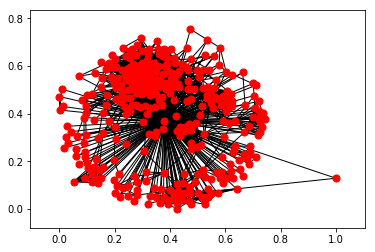

In [3]:
# draw network
g = nx.Graph(adj)
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Data Preprocessing

In [4]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
tf.set_random_seed(0)
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [5]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [6]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [7]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

np.random.seed(0) # IMPORTANT: guarantees consistent train/test splits
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [8]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", int(adj.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 348
Total edges: 2866
Training edges (positive): 1721
Training edges (negative): 1721
Validation edges (positive): 286
Validation edges (negative): 286
Test edges (positive): 859
Test edges (negative): 859


## 3. Initialize VAE Model

In [9]:
# Define hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 300
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [10]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [11]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [12]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

In [13]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        neg.append(adj_orig[e[0], e[1]]) # actual value (0)

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [14]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.94340 train_acc= 0.45906 val_roc= 0.79712 val_ap= 0.80699 time= 0.15010
Epoch: 0002 train_loss= 1.71087 train_acc= 0.46866 val_roc= 0.79640 val_ap= 0.80296 time= 0.05808
Epoch: 0003 train_loss= 1.47331 train_acc= 0.47842 val_roc= 0.79747 val_ap= 0.80064 time= 0.04247
Epoch: 0004 train_loss= 1.42446 train_acc= 0.46915 val_roc= 0.80191 val_ap= 0.80072 time= 0.04176
Epoch: 0005 train_loss= 1.35798 train_acc= 0.48294 val_roc= 0.80879 val_ap= 0.80580 time= 0.04005
Epoch: 0006 train_loss= 1.32575 train_acc= 0.48358 val_roc= 0.81789 val_ap= 0.81215 time= 0.04869
Epoch: 0007 train_loss= 1.31170 train_acc= 0.48803 val_roc= 0.82824 val_ap= 0.82300 time= 0.05095
Epoch: 0008 train_loss= 1.28302 train_acc= 0.48722 val_roc= 0.83459 val_ap= 0.83004 time= 0.04021
Epoch: 0009 train_loss= 1.25093 train_acc= 0.49032 val_roc= 0.83532 val_ap= 0.83447 time= 0.03957
Epoch: 0010 train_loss= 1.18308 train_acc= 0.49427 val_roc= 0.83444 val_ap= 0.83650 time= 0.04250
Epoch: 0011 train_lo

Epoch: 0086 train_loss= 0.54929 train_acc= 0.52007 val_roc= 0.84511 val_ap= 0.83809 time= 0.05852
Epoch: 0087 train_loss= 0.54760 train_acc= 0.52542 val_roc= 0.84475 val_ap= 0.83891 time= 0.06657
Epoch: 0088 train_loss= 0.55055 train_acc= 0.50755 val_roc= 0.84498 val_ap= 0.83952 time= 0.05376
Epoch: 0089 train_loss= 0.55087 train_acc= 0.51420 val_roc= 0.84394 val_ap= 0.83923 time= 0.03840
Epoch: 0090 train_loss= 0.54866 train_acc= 0.50973 val_roc= 0.84401 val_ap= 0.83992 time= 0.04128
Epoch: 0091 train_loss= 0.54472 train_acc= 0.52094 val_roc= 0.84471 val_ap= 0.84037 time= 0.04787
Epoch: 0092 train_loss= 0.54835 train_acc= 0.51257 val_roc= 0.84621 val_ap= 0.84059 time= 0.03922
Epoch: 0093 train_loss= 0.54455 train_acc= 0.51524 val_roc= 0.84881 val_ap= 0.84155 time= 0.03947
Epoch: 0094 train_loss= 0.54491 train_acc= 0.51972 val_roc= 0.85064 val_ap= 0.84276 time= 0.04106
Epoch: 0095 train_loss= 0.54529 train_acc= 0.52370 val_roc= 0.85071 val_ap= 0.84304 time= 0.04445
Epoch: 0096 train_lo

Epoch: 0170 train_loss= 0.53722 train_acc= 0.53143 val_roc= 0.85422 val_ap= 0.84807 time= 0.06242
Epoch: 0171 train_loss= 0.53207 train_acc= 0.53919 val_roc= 0.85283 val_ap= 0.84665 time= 0.09763
Epoch: 0172 train_loss= 0.53379 train_acc= 0.53179 val_roc= 0.84923 val_ap= 0.84330 time= 0.09450
Epoch: 0173 train_loss= 0.53911 train_acc= 0.51539 val_roc= 0.84618 val_ap= 0.84151 time= 0.08530
Epoch: 0174 train_loss= 0.54115 train_acc= 0.52528 val_roc= 0.84405 val_ap= 0.83991 time= 0.04759
Epoch: 0175 train_loss= 0.53638 train_acc= 0.53204 val_roc= 0.84735 val_ap= 0.84251 time= 0.04524
Epoch: 0176 train_loss= 0.53471 train_acc= 0.54409 val_roc= 0.85141 val_ap= 0.84569 time= 0.05064
Epoch: 0177 train_loss= 0.53692 train_acc= 0.53192 val_roc= 0.85372 val_ap= 0.84889 time= 0.04764
Epoch: 0178 train_loss= 0.53427 train_acc= 0.53201 val_roc= 0.85470 val_ap= 0.85012 time= 0.05700
Epoch: 0179 train_loss= 0.53938 train_acc= 0.52053 val_roc= 0.85469 val_ap= 0.84987 time= 0.04241
Epoch: 0180 train_lo

Epoch: 0258 train_loss= 0.52539 train_acc= 0.55024 val_roc= 0.85113 val_ap= 0.84715 time= 0.03618
Epoch: 0259 train_loss= 0.52607 train_acc= 0.53277 val_roc= 0.84831 val_ap= 0.84468 time= 0.04577
Epoch: 0260 train_loss= 0.52980 train_acc= 0.53470 val_roc= 0.84692 val_ap= 0.84349 time= 0.03674
Epoch: 0261 train_loss= 0.52956 train_acc= 0.53476 val_roc= 0.84963 val_ap= 0.84496 time= 0.03756
Epoch: 0262 train_loss= 0.53232 train_acc= 0.52941 val_roc= 0.85351 val_ap= 0.84905 time= 0.03616
Epoch: 0263 train_loss= 0.52625 train_acc= 0.54203 val_roc= 0.85679 val_ap= 0.85158 time= 0.03916
Epoch: 0264 train_loss= 0.52540 train_acc= 0.53959 val_roc= 0.85846 val_ap= 0.85390 time= 0.05049
Epoch: 0265 train_loss= 0.52553 train_acc= 0.54043 val_roc= 0.85919 val_ap= 0.85426 time= 0.03675
Epoch: 0266 train_loss= 0.52985 train_acc= 0.54664 val_roc= 0.85948 val_ap= 0.85476 time= 0.03665
Epoch: 0267 train_loss= 0.53045 train_acc= 0.53514 val_roc= 0.85846 val_ap= 0.85426 time= 0.03651
Epoch: 0268 train_lo